# The Hard Margin Linear SVM

**EE514: Data Analysis and Machine Learning**

[Kevin McGuinness](http://www.eeng.dcu.ie/~mcguinne/), School of Electronic Engineering, Dublin City University

---

Here we show how to solve the hard margin linear SVM by using the [CVXOPT](http://cvxopt.org) package to solve the corresponding quadratic program.

## Install CVXOPT

CVXOPT is a package for convex optimization. More Information on CVXOPT can be found at [cvxopt.org](https://cvxopt.org/).

In [ ]:
!pip3 install cvxopt

## Import packages and define some utility functions

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import cvxopt
import cvxopt.solvers
import seaborn as sns

In [ ]:
def load_dataset(fn):
    data = np.load(fn)
    return data['X'], data['y']

def plot_dataset(X, y):
    figure(figsize=(8,6))
    positives = X[y==1]
    negatives = X[y==-1]
    scatter(positives[:,0], positives[:,1], s=100, c='b', marker='*', label='positives')
    scatter(negatives[:,0], negatives[:,1], s=60, c='r', marker='^', label='negatives')
    legend()
    show()
    
def plot_decision_function(df, X, y):
    
    # Find span of data
    x0_min, x1_min = np.min(X, axis=0)
    x0_max, x1_max = np.max(X, axis=0)
    x0_range = x0_max - x0_min
    x1_range = x1_max - x1_min
    
    # Add small buffer around data
    x0_min = x0_min - 0.1 * x0_range
    x0_max = x0_max + 0.1 * x0_range
    x1_min = x1_min - 0.1 * x1_range
    x1_max = x1_max + 0.1 * x1_range
    
    # Generate linearly spaced points
    x0 = np.linspace(x0_min, x0_max, 100)
    x1 = np.linspace(x1_min, x1_max, 100)
    
    # Generate meshgrid
    X0, X1 = np.meshgrid(x0, x1)
    
    # Evaluate decision function for all points on the grid
    Y = df(np.c_[X0.ravel(), X1.ravel()]).reshape(X0.shape)
    
    
    # Plot the decision function
    figure(figsize=(8,6))
    contour(X0, X1, Y, levels=[-1,0,1], 
            linestyles=['dashed', 'solid', 'dashed'],
            linewidths=1,
            colors='k')
    
    # Plot the data
    positives = X[y==1]
    negatives = X[y==-1]
    scatter(positives[:,0], positives[:,1], s=100, c='b', marker='*', label='positives')
    scatter(negatives[:,0], negatives[:,1], s=100, c='r', marker='^', label='negatives')
    legend()
    show()

## Implement the hard margin linear SVM

Formulate the problem as a quadratic program (QP) and solve it using CVXOPT.

The function [cvxopt.solvers.qp](http://cvxopt.org/userguide/coneprog.html#quadratic-programming) solves quadratic programs of the form:
$$\begin{aligned}
    & \underset{x}{\text{minimize}}
    & & \frac{1}{2} x^T P x + q^T x\\
    & \text{subject to}
    & & Gx \leq h \\
    & & & Ax = b \\
    \end{aligned}$$
given matrices $P, G, A$ and vectors $q, h, b$. In the case of the hard margin linear SVM we only have inequality constraints so we don't need $A$ and $b$. See the [slides](https://loop.dcu.ie/mod/resource/view.php?id=662567) (slide 19) for details on how to cast the SVM in this form and find matrices $P, G$ and vectors $q, h$.

In [ ]:
class HardMarginSVM(object):
    
    def fit(self, X, y):
        n, m = X.shape
        mat = cvxopt.matrix
    
        # Formulate QP
        P = mat(np.eye(m+1))
        P[-1,-1] = 0
        q = mat(0.0, (m+1, 1))
        G = mat(np.c_[-y[:,np.newaxis] * X, -y])
        h = mat(-1.0, (n, 1))
    
        # Solve QP
        solution = cvxopt.solvers.qp(P, q, G, h)
        
        # Check to make sure we have the optimal solution
        if solution['status'] != 'optimal':
            raise ValueError('infeasible')
        
        # Assign model parameters w, b
        x = np.array(solution['x'])
        self.w = x[:-1].ravel()
        self.b = x[-1][0]
        
    def decision_function(self, X):
        return X @ self.w + self.b
    
    def predict(self, X):
        return np.where(self.decision_function(X) > 0, 1, -1)

## Load dataset

First we download a pre-made linearly separable dataset

In [ ]:
!curl -O# http://www.eeng.dcu.ie/~mcguinne/data/ee514/separable.npz
!ls -lah separable.npz

######################################################################## 100.0%
-rw-r--r-- 1 root root 834 Nov  4 00:15 separable.npz


Then load the dataset and plot it.

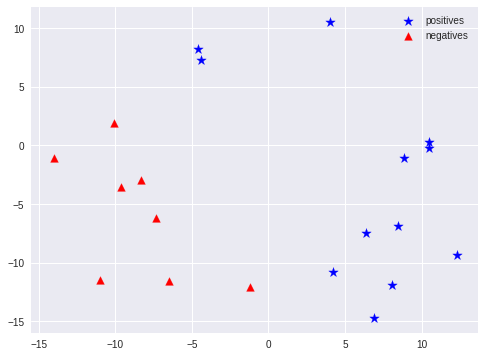

In [ ]:
X, y = load_dataset('separable.npz')
plot_dataset(X, y)

## Fit the hard margin SVM

Here we call `svm.fit` to to solve the quadratic program (QP) and find the weights and bias that give the best margin.

In [ ]:
svm = HardMarginSVM()
svm.fit(X, y)

     pcost       dcost       gap    pres   dres
 0:  6.1765e-03  9.3496e+00  5e+01  2e+00  2e+02
 1:  6.1007e-02 -6.4493e+00  1e+01  4e-01  5e+01
 2:  1.0537e-01 -6.6632e-01  8e-01  3e-02  3e+00
 3:  9.2261e-02  4.3199e-02  5e-02  7e-16  9e-16
 4:  6.8569e-02  6.4555e-02  4e-03  5e-16  6e-16
 5:  6.7730e-02  6.7286e-02  4e-04  6e-16  1e-15
 6:  6.7663e-02  6.7658e-02  5e-06  5e-16  8e-16
 7:  6.7662e-02  6.7662e-02  5e-08  6e-16  1e-15
Optimal solution found.


## Plot the decision boundary and data

Plot the resulting SVM decision boundary and margin. The points that lie on the margin are the support vectors.

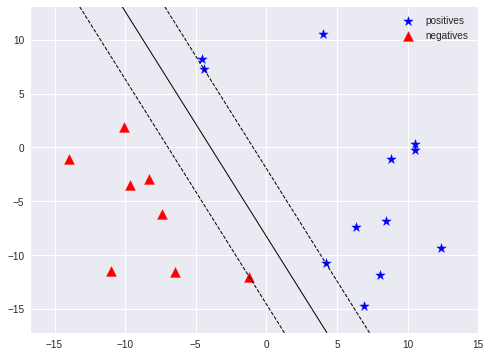

In [ ]:
plot_decision_function(svm.decision_function, X, y)

## Check predictions

Compare the predictions to the ground truth. Since the problem is linearly separable, we should achieve 100% accuracy on the training set.

In [ ]:
y_hat = svm.predict(X)
accuracy = (y==y_hat).sum() / float(y.shape[0]) 
print('Accuracy: {}%'.format(accuracy * 100))
print(y)
print(y_hat)

Accuracy: 100.0%
[ 1 -1  1 -1 -1  1  1  1 -1  1  1 -1  1 -1  1 -1  1  1  1 -1]
[ 1 -1  1 -1 -1  1  1  1 -1  1  1 -1  1 -1  1 -1  1  1  1 -1]


## Exercises

1. Change the code above to download and load the inseparable dataset at `http://www.eeng.dcu.ie/~mcguinne/data/ee514/nonseparable.npz` and try solve the QP using `svm.fit`. What happens and why?